In [25]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [26]:
func_dict = {}

In [27]:
def ld_data(dir_name):
    # Load data in files from directory dir_name in a pandas dataframe
    df = pd.DataFrame()
    for filename in os.listdir(dir_name):
        funcs = []
        with open(os.path.join(dir_name, filename), 'r') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                lib, func = line.split(' ')
                # lib = lib[2:-1]
                # func = func[2:-1]
                if '@' in func or '?' in func:
                    continue

                if not func.lower() in func_dict:
                    func_dict[func.lower()] = [(lib, func)]
                else:
                    func_dict[func.lower()].append((lib, func))

                funcs.append(func)

            # funcs = [line.strip().split(' ')[1][2:-1] for line in lines if not '@' in line.strip().split(' ')[1][2:-1] and not '?' in line.strip().split(' ')[1][2:-1]]

        # Concat all functions as string in df
        label = 'MALWARE' if filename.startswith('R') else 'GOODWARE'
        df = pd.concat([df, pd.DataFrame({'filename': filename, 'label': label, 'funcs': ' '.join(funcs)}, index=[0])], ignore_index=True)
        
    return df


In [28]:
train_dt_dir_name = '../data/executable-functions-5/'
test_dt_dir_name = '../data/executable-functions-6/'
# test_dt_dir_name = '/archive/files/imports/'

In [29]:
train = ld_data(train_dt_dir_name)
test = ld_data(test_dt_dir_name)

In [30]:
print(len(test))
print(len(test[test['label'] == 'MALWARE']))
print(len(test[test['label'] == 'GOODWARE']))
test_goodware = test[test['label'] == 'GOODWARE']
test_malware = test[test['label'] == 'MALWARE']

13645
8088
5557


In [31]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train['funcs']).ceil()
test_g_vectors = vectorizer.transform(test_goodware['funcs']).ceil()
test_m_vectors = vectorizer.transform(test_malware['funcs']).ceil()
test_vectors = vectorizer.transform(test['funcs']).ceil()

print(vectorizer.get_feature_names_out())
print(train['filename'][0])
print(train_vectors.toarray()[0])

['___lc_codepage_func' '___lc_collate_cp_func' '___lc_handle_func' ...
 'zwupdatewnfstatedata' 'zwwaitforsingleobject' 'zwwritefile']
G-bcdsrv.dll
[0. 0. 0. ... 0. 0. 0.]


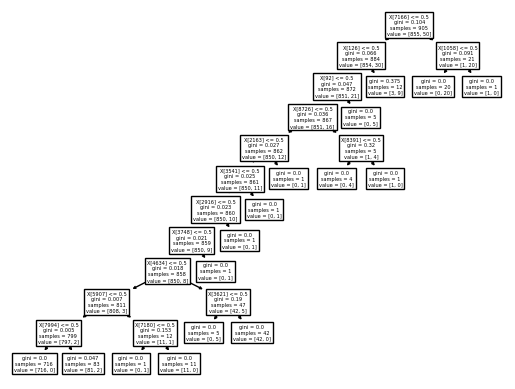

In [32]:
# Train the classifier
classifier = DecisionTreeClassifier()

classifier.fit(train_vectors, train['label'])
# Print information about the decision tree -- 31 features
plot_tree(classifier)
plt.savefig('decision_tree.svg')

In [33]:
pred_g = classifier.predict(test_g_vectors)
pred_m = classifier.predict(test_m_vectors)
pred_t = classifier.predict(test_vectors)

# Evaluate the classifier
print('Accuracy goodwares: {}'.format(accuracy_score(test_goodware['label'], pred_g)))
print('Accuracy malwares: {}'.format(accuracy_score(test_malware['label'], pred_m)))
print('Accuracy total: {}'.format(accuracy_score(test['label'], pred_t)))

Accuracy goodwares: 0.9485333813208566
Accuracy malwares: 0.8537339268051434
Accuracy total: 0.8923415170392085


In [24]:
print(vectorizer.get_feature_names_out()[7166])

rtlunwind


In [16]:
n_nodes = classifier.tree_.node_count
children_left = classifier.tree_.children_left
children_right = classifier.tree_.children_right
feature = classifier.tree_.feature
threshold = classifier.tree_.threshold
value = classifier.tree_.value
impurity = classifier.tree_.impurity


In [17]:
print(children_left)
print(children_right)
print(feature)
print(value)

[ 1  2  3  4  5  6  7  8  9 10 11 -1 -1 14 -1 -1 17 -1 -1 -1 -1 -1 -1 24
 -1 -1 -1 -1 29 -1 -1]
[28 27 26 23 22 21 20 19 16 13 12 -1 -1 15 -1 -1 18 -1 -1 -1 -1 -1 -1 25
 -1 -1 -1 -1 30 -1 -1]
[7166  126   92 8726 2163 3747 8632 3541 4634 5907 7994   -2   -2  596
   -2   -2 3621   -2   -2   -2   -2   -2   -2 2321   -2   -2   -2   -2
 8380   -2   -2]
[[[855.  50.]]

 [[854.  30.]]

 [[851.  21.]]

 [[851.  16.]]

 [[850.  12.]]

 [[850.  11.]]

 [[850.  10.]]

 [[850.   9.]]

 [[850.   8.]]

 [[808.   3.]]

 [[797.   2.]]

 [[716.   0.]]

 [[ 81.   2.]]

 [[ 11.   1.]]

 [[  0.   1.]]

 [[ 11.   0.]]

 [[ 42.   5.]]

 [[  0.   5.]]

 [[ 42.   0.]]

 [[  0.   1.]]

 [[  0.   1.]]

 [[  0.   1.]]

 [[  0.   1.]]

 [[  1.   4.]]

 [[  0.   4.]]

 [[  1.   0.]]

 [[  0.   5.]]

 [[  3.   9.]]

 [[  1.  20.]]

 [[  0.  20.]]

 [[  1.   0.]]]


In [18]:
def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] != -1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] != -1):
        right = find_path(children_right[node_numb], path, x)
    if left or right:
        return True
    path.remove(node_numb)
    return False


def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        # We check if we are not in the leaf
        if index != len(path) - 1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask


In [19]:
import yara
import yara_tools

In [20]:
def get_yara_rule(rule, condition_group, path, column_names):
    for index, node in enumerate(path):
        if index != len(path) - 1:
            func_lwr = column_names[feature[node]]
            if (children_left[node] == path[index+1]):
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="and")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'not(pe.imports("{lib}", "{func}"))', condition_group="{}_{}".format(condition_group, index))
            else:
                rule.create_condition_group(name="{}_{}".format(condition_group, index), parent_group=condition_group, default_boolean="or")
                for lib, func in func_dict[func_lwr]:
                    rule.add_condition(f'pe.imports("{lib}", "{func}")', condition_group="{}_{}".format(condition_group, index))


In [21]:
rule = yara_tools.create_rule(name="automatic_rule", default_boolean='or')

rule.add_import(name="pe")

In [22]:
# Leaves
leave_id = classifier.apply(train_vectors)

paths = {}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

# Cut paths that lead to goodwares
filtered_paths = {}
for path in paths:
    n_goodwares, n_malwares = value[path][0]
    if n_malwares > n_goodwares:
        filtered_paths[path] = paths[path]

paths = filtered_paths

for leaf_num in paths:
    rule.create_condition_group(name="group_{}".format(leaf_num), default_boolean='and')
    get_yara_rule(rule, "group_{}".format(leaf_num), paths[leaf_num], vectorizer.get_feature_names_out())

In [23]:
generated_rule = rule.build_rule(condition_groups=True)

compiled_rule = yara.compile(source=generated_rule)

print (generated_rule)

import "pe"

rule automatic_rule
{


	condition:
		((not(pe.imports("kernel32.dll", "RtlUnwind")) and not(pe.imports("ntdll.dll", "RtlUnwind")) and not(pe.imports("api-ms-win-core-rtlsupport-l1-1-0.dll", "RtlUnwind")) and not(pe.imports("api-ms-win-core-rtlsupport-l1-2-0.dll", "RtlUnwind"))) and (not(pe.imports("mscoree.dll", "_CorExeMain"))) and (not(pe.imports("msvcrt.dll", "_adjust_fdiv")) and not(pe.imports("msvcr90.dll", "_adjust_fdiv")) and not(pe.imports("msvcrt40.dll", "_adjust_fdiv")) and not(pe.imports("msvcr80.dll", "_adjust_fdiv"))) and (not(pe.imports("user32.dll", "wsprintfA"))) and (not(pe.imports("user32.dll", "DdeAccessData"))) and (not(pe.imports("opengl32.dll", "glDisable"))) and (not(pe.imports("mpr.dll", "WNetUseConnectionW"))) and (not(pe.imports("kernel32.dll", "GetQueuedCompletionStatusEx")) and not(pe.imports("api-ms-win-core-io-l1-1-0.dll", "GetQueuedCompletionStatusEx"))) and (not(pe.imports("kernel32.dll", "LoadLibraryA")) and not(pe.imports("api-ms-win-core